<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [ ]:
pip install -r requirements.txt


In [ ]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [ ]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Check whether GPU is available

In [ ]:
import torch
torch.cuda.is_available()

Load data from prepared local csv files

In [ ]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

Load price history
* Past covariates

In [ ]:
stocks_file = 'data/ibdgrowth_hist.csv.bz2'

In [ ]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0)
stocks_df



In [ ]:
stocks_df.columns.levels[0]

In [ ]:
import random

# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = 1024

stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


In [ ]:
print(list(stock_tickers))

In [ ]:
print(stock_tickers[0])

In [ ]:
n_epochs = 10 # model training epochs
# use only a small subset of stocks while testing impact of covariates on model performance
stock_tickers = random.sample(list(stock_tickers), 10)
# stock_tickers = list(stock_tickers) 
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist.drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


In [ ]:
ticker_dict.keys()

In [ ]:
type(list(ticker_dict.keys()))

In [ ]:
list(ticker_dict.keys())[0]

In [ ]:
# type(raw_df.index)

In [ ]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [ ]:
# raw_df

In [ ]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='B') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


Prepare multile series - one per stock ticker

In [ ]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



In [ ]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1991-01-01')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


In [ ]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    # print(f'ticker: {t} , {ticker_series[t]}')


In [ ]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [ ]:
ticker_series

In [ ]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [ ]:
# prepare target univariate price series per ticker
target_series = {t: ticker_series[t].univariate_component('Adj Close') for t in ticker_series.keys()}
target_series

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [ ]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=['Adj Close', 'holidays']) for t in ticker_series.keys()}

past_covariates


In [ ]:
past_covariates.keys()

In [ ]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples*2, figsize=(12, 4))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].drop_columns(['Volume']).plot(label=f'ticker {t} ', ax=axes[i])
        past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [ ]:
import pandas as pd

earnings_loaded_df = pd.read_csv('data/earnings_calendar.csv.bz2')
print(earnings_loaded_df)

In [ ]:
earnings_loaded_df.index.is_unique

In [ ]:
earnings_loaded_df.index

In [ ]:
len(earnings_loaded_df.index)

In [ ]:
earnings_loaded_df['date'] = pd.to_datetime(earnings_loaded_df['date'])

In [ ]:
earnings_unique = earnings_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [ ]:
assert not earnings_unique.duplicated().any()

In [ ]:
earnings_unique

In [ ]:
earnings_unique = earnings_unique.set_index(keys=['symbol', 'date'])

In [ ]:
earnings_unique

In [ ]:
assert earnings_unique.index.has_duplicates == False

In [ ]:
# check if data for a given symbol was saved and loaded as expected
earnings_unique.xs('LRN', level='symbol')

In [ ]:
print(earnings_unique.xs('LRN', level='symbol').head(n=20).to_string(index=True))

In [ ]:
# get a clean deep copy so it is easier to debug further data cleanup steps
earnings_expanded_df = earnings_unique.copy()

In [ ]:
# convert date strings to numerical representation
ufd = pd.to_datetime(earnings_expanded_df['updatedFromDate'])
ufd_year = ufd.dt.year
ufd_month = ufd.dt.month
ufd_day = ufd.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_year', value=ufd_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_month', value=ufd_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='updatedFromDate_day', value=ufd_day)
earnings_expanded_df.pop('updatedFromDate')


In [ ]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

In [ ]:
# convert date strings to numerical representation
fde = pd.to_datetime(earnings_expanded_df['fiscalDateEnding'])
fde_year = fde.dt.year
fde_month = fde.dt.month
fde_day = fde.dt.day

earn_n_cols = len(earnings_expanded_df.columns)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_year', value=fde_year)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_month', value=fde_month)
earnings_expanded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_day', value=fde_day)
earnings_expanded_df.pop('fiscalDateEnding')


In [ ]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

In [ ]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
earnings_expanded_df['time'] = earnings_expanded_df['time'].replace(['bmo', 'amc', '--', 'dmh'],
                        [0, 1, -1, -1], inplace=False).astype('int32')



In [ ]:
print(earnings_expanded_df.xs('LRN', level='symbol').head(n=20).to_string(index=True))

In [ ]:
from darts import TimeSeries

type(earnings_expanded_df.index)

In [ ]:
earnings_expanded_df.index.names

In [ ]:
earnings_expanded_df.dtypes

In [ ]:
# credit for implementation: https://stackoverflow.com/a/39068260/12015435
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))


In [ ]:
t_earn = earnings_expanded_df.loc[['LRN']]
t_earn = t_earn.droplevel('symbol')
t_earn.index = pd.to_datetime(t_earn.index)
print(f'index type for {t}: {type(t_earn.index)}')
assert not t_earn.index.duplicated().any()

for i in t_earn.index:
    if not is_business_day(i):
        print(f'earnings record date is not a business day: \n{t_earn.loc[[i]]}')



In [ ]:
len(t_earn.index)

In [ ]:
# align all dates with Business days
from pandas.tseries.offsets import BDay

def to_biz_day(date=None, report_time=None):
    if not is_business_day(date):
        if report_time == 1 or report_time =='amc':
                return date-BDay(n=1)
        else: 
            return date+BDay(n=1)
    else:
         return date

def align_to_business_days(t_earn=None):
    assert not t_earn.index.isnull().any()
    new_index = t_earn.index.map(lambda x : to_biz_day(date=x, report_time=t_earn.at[x, 'time']))
    t_earn.index = new_index
    if t_earn.index.isnull().any():
         print(t_earn[t_earn.index.isnull()])
    for i in t_earn.index:
        assert is_business_day(i)
    return t_earn


In [ ]:
# backfill quarterly earnigs and revenue estimates so that the model can see the next quarter's estimates during the previou s quarter days

def back_fill_earn_estimates(t_earn=None):
    t_earn['time'].bfill(inplace=True)
    t_earn['epsEstimated'].bfill(inplace=True)
    t_earn['revenueEstimated'].bfill(inplace=True)
    t_earn['fiscalDateEnding_day'].bfill(inplace=True)
    t_earn['fiscalDateEnding_month'].bfill(inplace=True)
    t_earn['fiscalDateEnding_year'].bfill(inplace=True)
    return t_earn



In [ ]:
# convert earnings dataframe to series

t_earn_series = {}
for t in list(ticker_series.keys()):
    print(f'ticker: {t}')
    t_earn = earnings_expanded_df.loc[[t]].copy()
    t_earn = t_earn.droplevel('symbol')
    t_earn.index = pd.to_datetime(t_earn.index)
    print(f'index type for {t}: {type(t_earn.index)}')
    assert not t_earn.index.duplicated().any()
    assert not t_earn.index.isnull().any()
    t_earn = align_to_business_days(t_earn)
    print(f't_earn freq: {t_earn.index}')
    tes_tmp = TimeSeries.from_dataframe(t_earn, freq='B', fill_missing_dates=True)
    t_earn = back_fill_earn_estimates(t_earn=tes_tmp.pd_dataframe())
    tes = TimeSeries.from_dataframe(t_earn, fillna_value=-1)
    assert len(tes.gaps()) == 0
    t_earn_series[t] = tes


In [ ]:
t

In [ ]:
t_earn


In [ ]:
print(t_earn.tail(n=330).to_string(index=True))

In [ ]:
t_earn.index

In [ ]:
tes.pd_dataframe()

In [ ]:
t_earn_series

In [ ]:
# stack sales and earnigns to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking future covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_earn_series[t])
    earn_sliced = t_earn_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(earn_sliced)
    print(f'past covariates for {t} including earnings calendar: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



In [ ]:
past_covariates = new_past_covs

In [ ]:
t

In [ ]:
past_covariates[t].start_time(), past_covariates[t].end_time()

In [ ]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


In [ ]:
t_earn_series[t].start_time(), t_earn_series[t].end_time()

### Add key metrics to past covariates

In [ ]:
kms_file = 'data/keymetrics_history.csv.bz2'


In [ ]:
import pandas as pd

kms_loaded_df = pd.read_csv(kms_file)
print(kms_loaded_df)

In [ ]:
assert kms_loaded_df.index.is_unique

In [ ]:
kms_loaded_df.index

In [ ]:
len(kms_loaded_df.index)

In [ ]:
kms_loaded_df['date'] = pd.to_datetime(kms_loaded_df['date'])

In [ ]:
kms_unique = kms_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [ ]:
assert not kms_unique.duplicated().any()

In [ ]:
kms_unique

In [ ]:
kms_unique = kms_unique.set_index(keys=['symbol', 'date'])

In [ ]:
kms_unique

In [ ]:
assert kms_unique.index.has_duplicates == False

In [ ]:
# check if data for a given symbol was saved and loaded as expected
kms_unique.xs('AAON', level='symbol')

In [ ]:
kms_loaded_df = kms_unique.copy()

In [ ]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
kms_loaded_df['period'] = kms_loaded_df['period'].replace(['Q1', 'Q2', 'Q3', 'Q4'],
                        [1, 2, 3, 4], inplace=False).astype('int32')

In [ ]:
kms_loaded_df

In [ ]:
from darts import TimeSeries

type(kms_loaded_df.index)

In [ ]:
kms_loaded_df.index.names

In [ ]:
kms_loaded_df.dtypes

In [ ]:
def df_index_to_biz_days(df=None):
    new_index = df.index.map(lambda x : to_biz_day(date=x))
    df.index = new_index
    return df



In [ ]:

def pad_kms(kms_series=None, price_series=None):
    """ 
    Pad a ticker's key metrics to align with price data
    """
    updated_kms_series = None
    if kms_series.end_time() < price_series.end_time():
        print(f'ticker {t} kms end time is before ticker price series end time: {kms_series.end_time()} < {price_series.end_time()}')
        tkms_df = kms_series.pd_dataframe()
        new_kms_df = tkms_df.reindex(price_series.pd_dataframe().index, method='ffill', copy=True)
        new_kms_ser = TimeSeries.from_dataframe(new_kms_df, freq='B', fillna_value=-1)
        print(f'ticker {t} kms end time after reindex: {new_kms_ser.end_time()}')
        updated_kms_series = new_kms_ser
    else:
        updated_kms_series = kms_series
    if kms_series.start_time() > price_series.start_time():
        print(f'ticker {t} kms start time is after ticker price series start time: {kms_series.start_time()} > {price_series.start_time()}')
    return updated_kms_series



In [ ]:
t_kms_series = {}
for t in list(ticker_series.keys()):
    print(f'ticker {t}')
    kms_df = kms_loaded_df.loc[[t]].copy()
    print(f'ticker_series[{t}] start time, end time: {ticker_series[t].start_time()}, {ticker_series[t].end_time()}')
    print(f'kms_ser_df start time, end time: {kms_df.index[0]}, {kms_df.index[-1]}')
    kms_df = kms_df.droplevel('symbol')
    kms_df.index = pd.to_datetime(kms_df.index)
    # print(f'index type for {t}: {type(t_kms.index)}')
    assert not kms_df.index.duplicated().any()
    # print(f'{t} earnings: \n{t_kms.columns}')
    kms_df = df_index_to_biz_days(kms_df)
    tkms_series_tmp = TimeSeries.from_dataframe(kms_df, freq='B', fill_missing_dates=True)
    print(f'kms_series_tmp start time, end time: {tkms_series_tmp.start_time()}, {tkms_series_tmp.end_time()}')
    kms_df_ext =tkms_series_tmp.pd_dataframe()
    kms_df_ext.ffill(inplace=True)
    kms_ser = TimeSeries.from_dataframe(kms_df, freq='B', fillna_value=-1)
    kms_ser_padded = pad_kms(kms_series=kms_ser, price_series=ticker_series[t])
    print(f'kms_ser_padded start time, end time: {kms_ser_padded.start_time()}, {kms_ser_padded.end_time()}')
    assert len(kms_ser_padded.gaps()) == 0, f'found gaps in tmks series: \n{kms_ser_padded.gaps()}'
    t_kms_series[t] = kms_ser_padded


In [ ]:
t_kms_series

In [ ]:
t

In [ ]:
kms_df

In [ ]:
kms_ser_padded.pd_dataframe()

In [ ]:
kms_ser_padded.pd_dataframe()

In [ ]:
# for c in kms_ser_padded.columns:
#    if len(kms_ser_padded[c].gaps()) > 0:
#        print(f'{c} NaNs: {len(kms_ser_padded[c].gaps())}')
#        print(kms_ser_padded[c].gaps())




In [ ]:
# stack key metrics to past covariates
new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking kms covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_kms_series[t])
    kms_sliced = t_kms_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(kms_sliced)
    print(f'past covariates for {t} including key metrics: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    # print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



In [ ]:
past_covariates = new_past_covs

In [ ]:
t

In [ ]:
past_covariates[t].start_time(), past_covariates[t].end_time()

In [ ]:
print(f'past covariates with key metrics sample: \n{past_covariates[t][0:5].pd_dataframe()}')


In [ ]:
t_kms_series[t].start_time(), t_kms_series[t].end_time()

### Add broad market indicators to past covariates

In [ ]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# drop Close as redundand
broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

In [ ]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

In [ ]:
broad_market_series.gaps()


In [ ]:

filler = MissingValuesFiller(n_jobs=-1)

series_filled = filler.transform(broad_market_series)
assert len(series_filled.gaps()) == 0

In [ ]:
broad_market_series = series_filled


In [ ]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


In [ ]:
print(f'past covariates without broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


In [ ]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    # print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


In [ ]:
print(f'past covariates with broad market indicies components: {past_covariates[t].components}')


In [ ]:
print(f'past covariates with broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


In [ ]:
# target_series['WRB'].pd_dataframe()

## Prepare Future Covariates

### Add holidays as future covariates

In [ ]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

### Add forward looking analyst estimates to future covariates

In [ ]:
fiscal_freq = {
    'annual': 'Y',
    'quarter': 'Q'
}

fiscal_periods = ['quarter', 'annual']


In [ ]:
import pandas as pd

def load_estimates(period=None):
    assert period in fiscal_periods
    est_file = f'data/analyst_estimates_{period}.csv.bz2'
    est_loaded_df = pd.read_csv(est_file)
    assert est_loaded_df.index.is_unique
    print(f'{period} estimates loaded: \n{est_loaded_df}')
    est_loaded_df['date'] = pd.to_datetime(est_loaded_df['date'])
    est_unique = est_loaded_df.drop_duplicates(subset=['symbol', 'date'])
    assert not est_unique.duplicated().any()
    est_unique = est_unique.set_index(keys=['symbol', 'date'])
    assert est_unique.index.has_duplicates == False
    assert est_unique.index.is_unique == True
    print(f'{period} estimates prepared: \n{est_unique}')
    return est_unique


In [ ]:
# loaded = load_estimates(period='quarter')

In [ ]:

def est_add_future_periods(est_df=None, n_future_periods=None, period=None):
    """
    Prepare time series with concatenated estimates for n_future_periods
    """
    # new_df = pd.DataFrame(index=est_df.index)
    print('est_df', est_df)
    # add fiscalDateEnding columns
    # fde = pd.to_datetime(est_df.index)
    fde_year = est_df.index.year
    fde_month = est_df.index.month
    fde_day = est_df.index.day
    n_cols = len(est_df.columns)
    est_expanded_df = est_df.copy()
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_year', value=fde_year)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_month', value=fde_month)
    est_expanded_df.insert(loc=n_cols, column='fiscalDateEnding_day', value=fde_day)
    # shift date index by future period delta 
    # so it can align and merge with the time series where the future period estimate columns will be used as past covariates
    est_shifted_df = est_expanded_df.copy()
    # https://pandas.pydata.org/docs/reference/api/pandas.Index.shift.html
    prange = range(1, n_future_periods+1)
    assert est_shifted_df.index.is_unique == True
    est_shifted_df = est_shifted_df.shift(periods=prange, suffix='_p') # freq=fiscal_freq[period], 
    print('est_shifted_df\n', est_shifted_df)
    # est_shifted_df.add_suffix(f'_p{n}')
    # new_df.join(est_shifted_df, how='outer', sort=True, validate='1:1')
    new_df = est_shifted_df
    # print('new_df', new_df)
    return new_df




In [ ]:

def prepare_est_series(all_est_df=None, n_future_periods=None, period=None):
    """
    Prepare future covariate series with analyst estimates for a given period (annual or quarter).
    :param all_est_df: estimates dataframe indexed by ['symbol', 'date']
    :param n_future_periods: number of periods of future estimates to make visible at each timeseries date
    :param period: quarter or annual
    :return: estimate series expanded with forward periods at each series date indexed row
    """
    assert period in fiscal_periods
    t_est_series = {}
    for t in list(ticker_series.keys()):
        print(f'ticker {t}')
        try:
            est_df = all_est_df.loc[[t]].copy()
            est_df = est_df.droplevel('symbol')
            est_df.index = pd.to_datetime(est_df.index)
            assert not est_df.index.duplicated().any()
            # expand series with estimates from future periods
            est_df = est_add_future_periods(est_df=est_df, n_future_periods=n_future_periods, period=period)
            # print(f'{t} estimates columns: \n{est_df.columns}')
            # align dates to business days
            est_df = df_index_to_biz_days(est_df)
            # expand date index to match target price series dates and pad data
            est_series_tmp = TimeSeries.from_dataframe(est_df, freq='B', fill_missing_dates=True)
            print(f'est_series_tmp start time, end time: {est_series_tmp.start_time()}, {est_series_tmp.end_time()}')
            est_df=est_series_tmp.pd_dataframe()
            est_df.ffill(inplace=True)
            est_ser = TimeSeries.from_dataframe(est_df, freq='B', fillna_value=-1)
            assert len(est_ser.gaps()) == 0, f'found gaps in tmks series: \n{est_ser.gaps()}'
            t_est_series[t] = est_ser
        except KeyError as e:
            print(f'No analyst estimates available for {t}')
    return t_est_series


In [ ]:
q_loaded_df = load_estimates(period='quarter')


#### Load quarterly analyst estimates

In [ ]:
quarter_est_series = prepare_est_series(all_est_df=q_loaded_df, n_future_periods=4, period='quarter')

In [ ]:
# qdf = quarter_est_series['ALTR'].pd_dataframe()

In [ ]:
# p=1
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [ ]:
# p=2
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [ ]:
# p=3
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [ ]:
# p=4
# qdf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

#### Load annual analyst estimates

In [ ]:
annual_loaded_df = load_estimates(period='annual')


In [ ]:
annual_loaded_df

In [ ]:
annual_est_series = prepare_est_series(all_est_df=annual_loaded_df, n_future_periods=2, period='annual')

In [ ]:
annual_est_series

In [ ]:
# adf = annual_est_series['ALTR'].pd_dataframe()

In [ ]:
# adf

In [ ]:
# p=1
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [ ]:
# p=2
# adf[[f'estimatedRevenueLow_p_{p}', f'fiscalDateEnding_year_p_{p}', f'fiscalDateEnding_month_p_{p}', f'fiscalDateEnding_day_p_{p}']]

In [204]:
tickers_with_incomplete_data = set()

def stack_covariates(current_covariates=None, new_covariates=[]):
    all_stacked_covariates = {}
    for t, covs in current_covariates.items():
        print(f'current covs for {t} has {len(covs.columns)} columns')
        print(f'current covs for {t} start time, end time {covs.start_time()} , {covs.end_time()}')
        missing_data = False
        for new_cov in new_covariates:
            if new_cov.get(t) is None: 
                missing_data = True
        if not missing_data:
            stacked_covs = covs
            for new_cov in new_covariates:
                assert type(new_cov[t]) == TimeSeries, f'type of {t} is not TimeSeries, but {type(new_cov[t])}'
                new_cov_sliced = new_cov[t].slice_intersect(stacked_covs)
                print(f'stacking new {t} covs with {len(new_cov_sliced.columns)} new columns')
                print(f'new covs for {t} total count, start time, end time: {len(new_cov_sliced)}, {new_cov_sliced.start_time()} , {new_cov_sliced.end_time()}')
                stacked_covs = stacked_covs.slice_intersect(new_cov_sliced)
                print(f'intersected covs for {t} total count, start time, end time: {len(stacked_covs)}, {stacked_covs.start_time()} , {stacked_covs.end_time()}')
                stacked_covs = stacked_covs.stack(new_cov_sliced)
                print(f'total stacked {t} columns {len(stacked_covs.columns)}')
            print(f'{t} stacked covs columns: {stacked_covs.columns}')
            if len(stacked_covs) >= min_samples:
                all_stacked_covariates[t] = stacked_covs
    return all_stacked_covariates



In [205]:
# Stack analyst estimates to future covariates
stacked_covariates = stack_covariates(current_covariates=future_covariates, new_covariates=[quarter_est_series, annual_est_series])


current covs for GBDC has 139 columns
current covs for GBDC start time, end time 2010-09-30 00:00:00 , 2024-01-12 00:00:00
stacking new GBDC covs with 92 new columns
new covs for GBDC total count, start time, end time: 3467, 2010-09-30 00:00:00 , 2024-01-12 00:00:00
intersected covs for GBDC total count, start time, end time: 3467, 2010-09-30 00:00:00 , 2024-01-12 00:00:00
total stacked GBDC columns 231
stacking new GBDC covs with 46 new columns
new covs for GBDC total count, start time, end time: 3467, 2010-09-30 00:00:00 , 2024-01-12 00:00:00
intersected covs for GBDC total count, start time, end time: 3467, 2010-09-30 00:00:00 , 2024-01-12 00:00:00
total stacked GBDC columns 277
GBDC stacked covs columns: Index(['holidays', 'estimatedRevenueLow_p_1', 'estimatedRevenueHigh_p_1',
       'estimatedRevenueAvg_p_1', 'estimatedEbitdaLow_p_1',
       'estimatedEbitdaHigh_p_1', 'estimatedEbitdaAvg_p_1',
       'estimatedEbitLow_p_1', 'estimatedEbitHigh_p_1', 'estimatedEbitAvg_p_1',
       .

In [206]:
stacked_covariates

{'GBDC': <TimeSeries (DataArray) (Date: 3467, component: 277, sample: 1)>
 array([[[0.0000000e+00],
         [8.3728010e+06],
         [9.9623720e+06],
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0120000e+03]],
 
        [[0.0000000e+00],
         [8.3728010e+06],
         [9.9623720e+06],
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0120000e+03]],
 
        [[0.0000000e+00],
         [8.3728010e+06],
         [9.9623720e+06],
         ...,
 ...
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0240000e+03]],
 
        [[0.0000000e+00],
         [6.4430424e+07],
         [9.6645638e+07],
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0240000e+03]],
 
        [[0.0000000e+00],
         [6.4430424e+07],
         [9.6645638e+07],
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0240000e+03]]])
 Coordinates:
   * Date       (Date) dateti

In [207]:
stacked_covariates.keys()

dict_keys(['GBDC', 'MEDP', 'BSX', 'WFC', 'TGH', 'OSW'])

In [208]:
future_covariates = stacked_covariates

In [212]:
future_covariates

{'GBDC': <TimeSeries (DataArray) (Date: 3467, component: 277, sample: 1)>
 array([[[0.0000000e+00],
         [8.3728010e+06],
         [9.9623720e+06],
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0120000e+03]],
 
        [[0.0000000e+00],
         [8.3728010e+06],
         [9.9623720e+06],
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0120000e+03]],
 
        [[0.0000000e+00],
         [8.3728010e+06],
         [9.9623720e+06],
         ...,
 ...
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0240000e+03]],
 
        [[0.0000000e+00],
         [6.4430424e+07],
         [9.6645638e+07],
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0240000e+03]],
 
        [[0.0000000e+00],
         [6.4430424e+07],
         [9.6645638e+07],
         ...,
         [3.0000000e+01],
         [9.0000000e+00],
         [2.0240000e+03]]])
 Coordinates:
   * Date       (Date) dateti

In [213]:
# len(future_covariates[t].columns)

## Reconcile data sets

In [214]:
# focus on tickers that we have full data sets for training and validation
target_set = set(target_series.keys())
future_set = set(future_covariates.keys())
past_set = set(past_covariates.keys())
tickers_with_complete_data = target_set&future_set&past_set
tickers_without_complete_data = (target_set|future_set|past_set)-tickers_with_complete_data
print(f'Removing time series for tickers with incomplete data sets: {tickers_without_complete_data}. Keeping {tickers_with_complete_data} ')

Removing time series for tickers with incomplete data sets: {'FERG'}. Keeping {'GBDC', 'MEDP', 'BSX', 'WFC', 'TGH', 'OSW'} 


In [215]:
new_target_series = {}
new_future_covariates = {}
new_past_covariates = {}

for t in tickers_with_complete_data:
    new_target_series[t] = target_series[t]
    new_future_covariates[t] = future_covariates[t]
    new_past_covariates[t] = past_covariates[t]


In [217]:
target_series = new_target_series
future_covariates = new_future_covariates
past_covariates = new_past_covariates

### Realign target series with past covariates

In [218]:
for t, covs in past_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    past_covariates[t] = covs_sliced

### Realign target series with future covariates

In [219]:
for t, covs in future_covariates.items():
    ts_sliced = target_series[t].slice_intersect(covs)
    target_series[t] = ts_sliced
    covs_sliced = covs.slice_intersect(ts_sliced)
    future_covariates[t] = covs_sliced

## Prepare train and validation splits

In [220]:
val_start = pd.Timestamp('2023-05-05')


### Drop series that do not have sufficient training data

In [221]:
# remove tickers that don't have sufficient training data
target_series_ok = {}

for t, target in target_series.items():
    # only include tickers with sufficient data for training
    if target.end_time() > val_start:
        target_series_ok[t] = target
    else:
        del past_covariates[t]
        del future_covariates[t]
        print(f'preparing train, val split for {t}')
        print(f'{t} is not OK. Filtering it out from target series. \n Reason: start time, end time, val_start: {target.start_time()}, {target.end_time()}, {val_start}')



In [222]:
target_series = target_series_ok

In [223]:
train_series = {}
val_series = {}
past_covariates_train = {}
past_covariates_val = {}

for t, target in target_series.items():
    print(f'preparing train, val split for {t}')
    print(f'{t} start time, end time: {target.start_time()}, {target.end_time()}')
    train, val = target.split_before(val_start)
    # there should be no gaps in the training data
    assert(len(train.gaps().index) == 0)
    train_series[t] = train
    val_series[t] = val
    past_train, past_val = past_covariates[t].split_before(val_start)
    # there should be no gaps in the training data
    assert(len(past_train.gaps().index) == 0)
    past_covariates_train[t] = past_train 
    past_covariates_val = past_val



preparing train, val split for GBDC
GBDC start time, end time: 2010-09-30 00:00:00, 2024-01-12 00:00:00
preparing train, val split for MEDP
MEDP start time, end time: 2017-01-02 00:00:00, 2024-01-12 00:00:00
preparing train, val split for BSX
BSX start time, end time: 1996-12-31 00:00:00, 2024-01-12 00:00:00
preparing train, val split for WFC
WFC start time, end time: 1996-12-31 00:00:00, 2024-01-12 00:00:00
preparing train, val split for TGH
TGH start time, end time: 2007-12-31 00:00:00, 2024-01-12 00:00:00
preparing train, val split for OSW
OSW start time, end time: 2019-12-31 00:00:00, 2024-01-12 00:00:00


In [224]:
train_series, val_series

({'GBDC': <TimeSeries (DataArray) (Date: 3286, component: 1, sample: 1)>
  array([[[ 5.11911154]],
  
         [[ 5.2930932 ]],
  
         [[ 5.19940758]],
  
         ...,
  
         [[12.03764343]],
  
         [[12.09286213]],
  
         [[12.01923847]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2010-09-30 2010-10-01 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'MEDP': <TimeSeries (DataArray) (Date: 1654, component: 1, sample: 1)>
  array([[[ 35.98999977]],
  
         [[ 35.90999985]],
  
         [[ 36.38999939]],
  
         ...,
  
         [[200.27999878]],
  
         [[205.47999573]],
  
         [[205.19000244]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2017-01-02 2017-01-03 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covari

In [225]:
past_covariates_train, past_covariates_val

({'GBDC': <TimeSeries (DataArray) (Date: 3286, component: 116, sample: 1)>
  array([[[ 14.87757111],
          [ 15.19098854],
          [ 14.81880474],
          ...,
          [ 79.01999664],
          [ 78.41000366],
          [ 78.72000122]],
  
         [[ 15.07345676],
          [ 15.50440693],
          [ 14.94613075],
          ...,
          [ 78.83000183],
          [ 78.02999878],
          [ 78.08999634]],
  
         [[ 15.49461269],
          [ 15.49461269],
          [ 15.16160583],
          ...,
  ...
          ...,
          [102.40000153],
          [101.87999725],
          [101.95999908]],
  
         [[ 13.17000008],
          [ 13.34000015],
          [ 13.13000011],
          ...,
          [101.91999817],
          [101.06999969],
          [101.33999634]],
  
         [[ 13.03999996],
          [ 13.06999969],
          [ 12.77999973],
          ...,
          [101.63999939],
          [101.02999878],
          [101.40000153]]])
  Coordinates:
    * Date      

Plot data splits

Text(0, 0.5, 'Target Series')

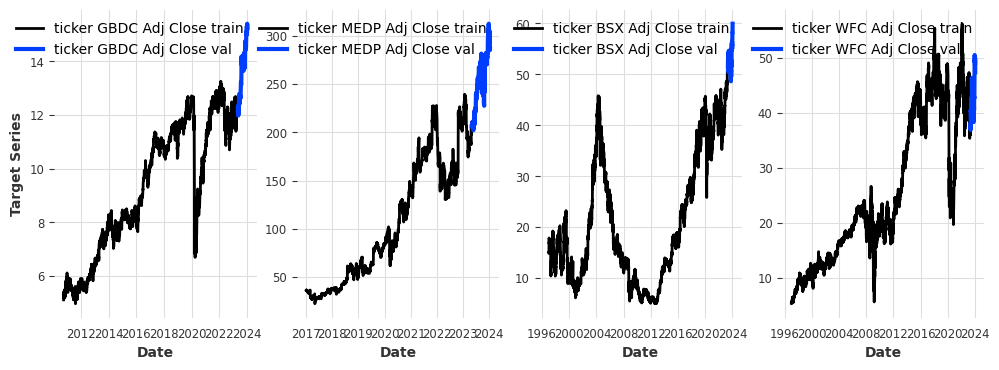

In [226]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break
    train_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} train', ax=axes[i])
    val_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} val', lw=3, ax=axes[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

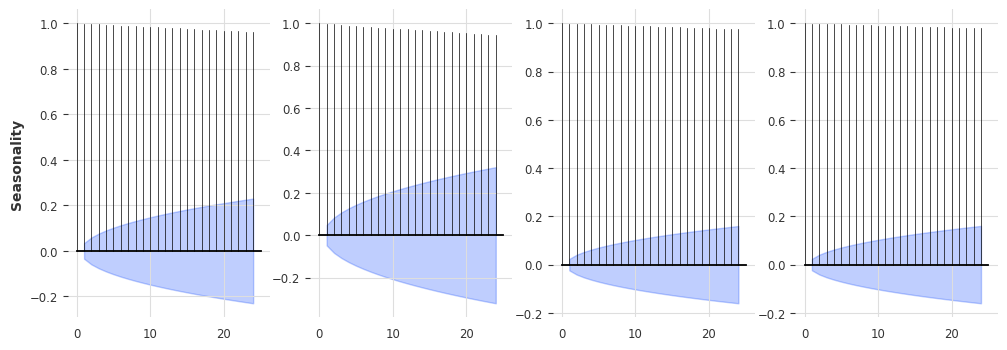

In [227]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i >= n_plot_samples:
        break
    plot_acf(train_series[t], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



## Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [228]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
# scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



In [229]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data


Model hyperparameter selection

In [230]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 2.24e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [231]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=None, # encoders,
      hidden_size=512,
      num_encoder_layers=2,
      num_decoder_layers=2,
      decoder_output_dim=32,
      temporal_decoder_hidden=64,
      dropout=0.2,
      use_layer_norm=True,
      use_reversible_instance_norm=True,
      n_epochs=n_epochs,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
      log_tensorboard=True
  )
  


Loading saved model
Error loading saved model: [Errno 2] No such file or directory: 'data/canswim_model.pt'
Creating a new model


In [232]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [233]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_train_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


6
6
6
6


In [234]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [235]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))
print(len(future_cov_list[0].time_index))


6873
6873
7054


In [236]:
target_train_list[0].pd_dataframe()

component,Adj Close
Date,
1996-12-31,15.000000
1997-01-01,14.921875
1997-01-02,14.843750
1997-01-03,15.000000
1997-01-06,14.937500
...,...
2023-04-28,52.119999
2023-05-01,52.799999
2023-05-02,52.900002


In [237]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('1996-12-31 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [238]:
past_cov_list[0].pd_dataframe().columns

Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       ...
       '^TNX_Adj Close', '^SPX_Open', '^SPX_High', '^SPX_Low',
       '^SPX_Adj Close', '^SPX_Volume', 'DX-Y.NYB_Open', 'DX-Y.NYB_High',
       'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close'],
      dtype='object', name='component', length=116)

In [239]:
past_cov_list[0].pd_dataframe()

component,Open,High,Low,Volume,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,...,^TNX_Adj Close,^SPX_Open,^SPX_High,^SPX_Low,^SPX_Adj Close,^SPX_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1996-12-31,15.218750,15.250000,15.000000,931600.0,-1.0,0.11,0.0,-1.0,4.087000e+08,-1.0,...,6.4070,753.849976,753.950012,740.739990,740.739990,3.997600e+08,88.849998,88.900002,88.029999,88.180000
1997-01-01,15.140625,15.187500,14.828125,1083000.0,-1.0,0.11,0.0,-1.0,4.087000e+08,-1.0,...,6.4655,747.294983,748.380005,735.144989,738.875000,4.314950e+08,88.849998,88.900002,88.029999,88.180000
1997-01-02,15.062500,15.125000,14.656250,1234400.0,-1.0,0.11,0.0,-1.0,4.087000e+08,-1.0,...,6.5240,740.739990,742.809998,729.549988,737.010010,4.632300e+08,88.400002,88.559998,88.150002,88.360001
1997-01-03,14.843750,15.000000,14.781250,1348800.0,-1.0,0.11,0.0,-1.0,4.087000e+08,-1.0,...,6.4980,737.010010,748.239990,737.010010,748.030029,4.529700e+08,88.459999,89.470001,88.379997,89.300003
1997-01-06,15.062500,15.187500,14.875000,1262400.0,-1.0,0.11,0.0,-1.0,4.087000e+08,-1.0,...,6.5200,748.030029,753.309998,743.820007,747.650024,5.313500e+08,89.410004,89.599998,89.110001,89.110001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,51.880001,52.860001,51.720001,13505100.0,-1.0,0.49,0.0,-1.0,3.502270e+09,-1.0,...,3.4520,4129.629883,4170.060059,4127.180176,4169.479980,4.087800e+09,101.470001,102.169998,101.419998,101.669998
2023-05-01,52.200001,52.860001,52.090000,7483500.0,-1.0,0.49,0.0,-1.0,3.502270e+09,-1.0,...,3.5740,4166.790039,4186.919922,4164.120117,4167.870117,3.321370e+09,101.669998,102.190002,101.620003,102.150002
2023-05-02,52.820000,53.470001,52.240002,8739200.0,-1.0,0.49,0.0,-1.0,3.502270e+09,-1.0,...,3.4390,4164.100098,4164.100098,4089.719971,4119.580078,4.486130e+09,102.150002,102.400002,101.879997,101.959999


In [240]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('1996-12-31 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [241]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays                                   2.740000e+02
estimatedRevenueLow_p_1                    1.063104e+13
estimatedRevenueHigh_p_1                   1.319215e+13
estimatedRevenueAvg_p_1                    1.188078e+13
estimatedEbitdaLow_p_1                    -8.780648e+09
                                               ...     
numberAnalystEstimatedRevenue_p_2_1_1_1    3.816810e+05
numberAnalystsEstimatedEps_p_2_1_1_1       3.238820e+05
fiscalDateEnding_day_p_2_1_1_1             2.186740e+05
fiscalDateEnding_month_p_2_1_1_1           8.464800e+04
fiscalDateEnding_year_p_2_1_1_1            1.418573e+07
Length: 277, dtype: float64

In [242]:
future_cov_list[0].columns

Index(['holidays', 'estimatedRevenueLow_p_1', 'estimatedRevenueHigh_p_1',
       'estimatedRevenueAvg_p_1', 'estimatedEbitdaLow_p_1',
       'estimatedEbitdaHigh_p_1', 'estimatedEbitdaAvg_p_1',
       'estimatedEbitLow_p_1', 'estimatedEbitHigh_p_1', 'estimatedEbitAvg_p_1',
       ...
       'estimatedSgaExpenseHigh_p_2_1_1_1', 'estimatedSgaExpenseAvg_p_2_1_1_1',
       'estimatedEpsAvg_p_2_1_1_1', 'estimatedEpsHigh_p_2_1_1_1',
       'estimatedEpsLow_p_2_1_1_1', 'numberAnalystEstimatedRevenue_p_2_1_1_1',
       'numberAnalystsEstimatedEps_p_2_1_1_1',
       'fiscalDateEnding_day_p_2_1_1_1', 'fiscalDateEnding_month_p_2_1_1_1',
       'fiscalDateEnding_year_p_2_1_1_1'],
      dtype='object', name='component', length=277)

In [243]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('1996-12-31 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [244]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, verbose=True, num_loader_workers=10, )
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 16.0 K
5 | future_cov_projection | _ResidualBlock   | 37.2 K
6 | encoders              | Sequential       | 1.2 M 
7 | decoders              | Sequential       | 1.2 M 
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.669    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

### Save model checkpoint

In [ ]:
# save model checkpoint
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

## Test Model Forecasting

In [ ]:
pred[0]

In [ ]:
pred[0].gaps()

In [ ]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

### Plot several forecasts at various future starting points

In [ ]:
import matplotlib.dates as mdates

# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))


def get_pred_list(pred_start=None):
    pred_list = []
    for t, target in sorted(target_series.items()):
        pred_series = target.slice(target.start_time(), pred_start-pd.Timedelta(days=1))
        pred_list.append(pred_series)
    return pred_list


def get_past_covs(start=None):
    past_cov_list = []
    for t, past_cov in sorted(past_covariates.items()):
        past_covs_sliced = past_cov.slice(past_cov.start_time(), pred_start-pd.Timedelta(days=1))
        past_cov_list.append(past_covs_sliced)
    return past_cov_list


def plot_pred(pred_list=None, past_cov_list=None):
    #pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
    pred = model.predict(pred_horizon, series=pred_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            # tsliced = target_series[t]
            # actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            # ax = actual[t].plot(label='actual', ax=axes[i])
            ax = pred[i].plot(label=f'forecast {pred_list[0].end_time()} + {pred_horizon}', linewidth=2, ax=axes[i])
            #pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
            plt.legend()
            # Major ticks every half year, minor ticks every month,
            ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
            ax.xaxis.set_minor_locator(mdates.MonthLocator())
            ax.grid(True)
            ax.set_ylabel(f'{t}')


def plot_actual():
    for i,t in enumerate(sorted(train_series.keys())):
        if i < n_plot_samples:
            tsliced = target_series[t]
            actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
            ax = actual[t].plot(label='actual', linewidth=1, ax=axes[i])

plot_actual()

# show predictions at several points in time over the validation set
for w in range(5):
    pred_start = val_start + pd.Timedelta(days=w*pred_horizon)
    pred_list = get_pred_list(pred_start)
    past_cov_list = get_past_covs(pred_start)
    # print(f'pred_list: \n{pred_list}')
    plot_pred(pred_list=pred_list, past_cov_list=past_cov_list)



### Backtest Model


In [ ]:
# Backtest model on the full range of test data
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [ ]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=120)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list[:n_plot_samples], start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list[:n_plot_samples], future_covariates=future_cov_list[:n_plot_samples])


In [ ]:

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        backtest[i].plot(label=f'backtest (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [ ]:
print('Backtest RMSE = {}'.format(rmse(target_train_list[:n_plot_samples], backtest)))
